2024-12-27 23:16:34.320122: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 23:16:34.337660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735341394.361785    9367 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735341394.371591    9367 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 23:16:34.404643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

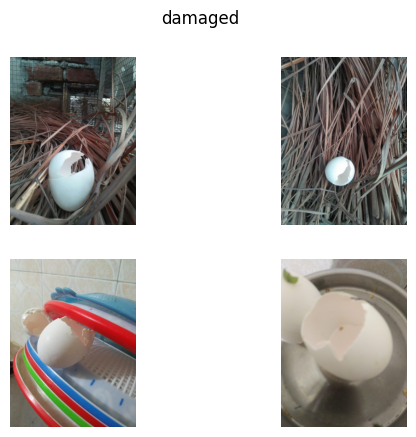

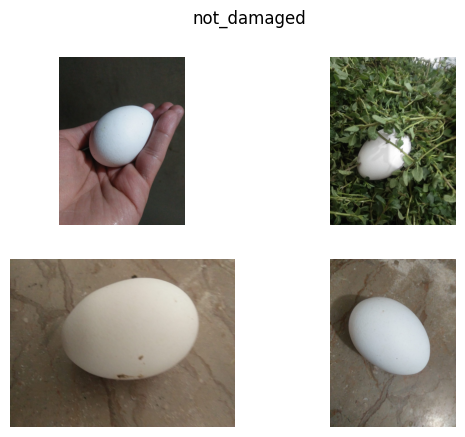

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

path = 'eggs_images/'
categories = ['damaged', 'not_damaged']
image_size = (224, 224)

# Візуалізація прикладів
for category in categories:
    fig, _ = plt.subplots(2, 2)
    fig.suptitle(category)
    for k, v in enumerate(os.listdir(path + category)[:4]):
        img = plt.imread(path + category + '/' + v)
        plt.subplot(2, 2, k + 1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [2]:
X = []
y = []

for k, category in enumerate(categories):
    category_path = os.path.join(path, category)
    for f in os.listdir(category_path):
        image = cv2.imread(os.path.join(category_path, f))
        if image is not None:
            image = cv2.resize(image, image_size)
            X.append(image)
            y.append(k)

X = np.array(X, dtype="float32") / 255.0  # Нормализация
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, len(categories))
y_test = to_categorical(y_test, len(categories))

In [3]:
model_scratch = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

model_scratch.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_scratch = model_scratch.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

results_scratch = model_scratch.evaluate(X_test, y_test, verbose=0)
print('From Scratch - Losses:', results_scratch[0])
print('From Scratch - Accuracy:', results_scratch[1])

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=predictions)

model_tl.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_tl = model_tl.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)

results_tl = model_tl.evaluate(X_test, y_test, verbose=0)
print('Transfer Learning - Losses:', results_tl[0])
print('Transfer Learning - Accuracy:', results_tl[1])

/home/user/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1735341413.875243    9367 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/10


I0000 00:00:1735341416.671845    9468 service.cc:148] XLA service 0x7fd618005210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735341416.672025    9468 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2024-12-27 23:16:56.720109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735341416.837429    9468 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5834 - loss: 1.0207

I0000 00:00:1735341418.689523    9468 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.6996 - loss: 0.7967 - val_accuracy: 0.7547 - val_loss: 0.5424
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8135 - loss: 0.4652 - val_accuracy: 0.7547 - val_loss: 0.4869
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8331 - loss: 0.4265 - val_accuracy: 0.8302 - val_loss: 0.3516
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8975 - loss: 0.2939 - val_accuracy: 0.8365 - val_loss: 0.3635
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8905 - loss: 0.2711 - val_accuracy: 0.8239 - val_loss: 0.3802
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8982 - loss: 0.2528 - val_accuracy: 0.8553 - val_loss: 0.3342
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8736 - loss: 0.2949 - val_accuracy: 0.8553 - val_loss: 0.2869
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9203 - loss: 0.2194 - val_accuracy: 0.8679 - val_loss: 0

2024-12-27 23:17:19.576890: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1179', 144 bytes spill stores, 144 bytes spill loads

2024-12-27 23:17:19.628922: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1179', 520 bytes spill stores, 520 bytes spill loads

2024-12-27 23:17:20.928902: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1179', 100 bytes spill stores, 100 bytes spill loads

2024-12-27 23:17:20.948462: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1179', 584 bytes spill stores, 508 bytes spill loads



20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - accuracy: 0.7372 - loss: 0.7085 - val_accuracy: 0.8239 - val_loss: 0.3854
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8090 - loss: 0.4060 - val_accuracy: 0.8868 - val_loss: 0.2793
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8956 - loss: 0.2587 - val_accuracy: 0.9182 - val_loss: 0.2460
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8729 - loss: 0.2413 - val_accuracy: 0.9308 - val_loss: 0.2041
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9123 - loss: 0.1859 - val_accuracy: 0.9308 - val_loss: 0.2035
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9304 - loss: 0.1592 - val_accuracy: 0.9308 - val_loss: 0.1823
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9356 - loss: 0.1624 - val_accuracy: 0.9434 - val_loss: 0.2033
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9620 - loss: 0.1147 - val_accuracy: 0.9497 - val_loss: 

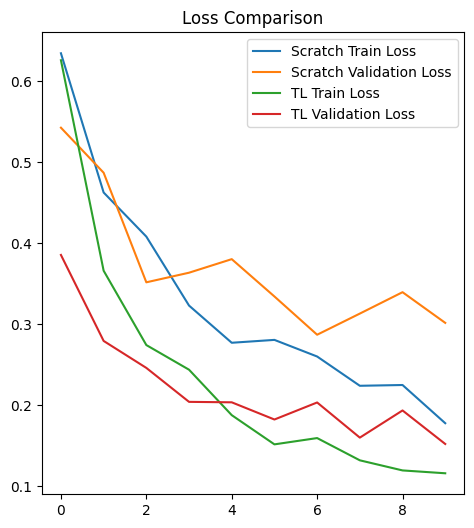

In [4]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_scratch.history['loss'], label='Scratch Train Loss')
plt.plot(history_scratch.history['val_loss'], label='Scratch Validation Loss')
plt.plot(history_tl.history['loss'], label='TL Train Loss')
plt.plot(history_tl.history['val_loss'], label='TL Validation Loss')
plt.title('Loss Comparison')
plt.legend()

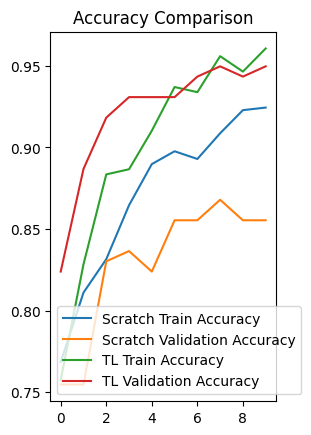

In [5]:
plt.subplot(1, 2, 2)
plt.plot(history_scratch.history['accuracy'], label='Scratch Train Accuracy')
plt.plot(history_scratch.history['val_accuracy'], label='Scratch Validation Accuracy')
plt.plot(history_tl.history['accuracy'], label='TL Train Accuracy')
plt.plot(history_tl.history['val_accuracy'], label='TL Validation Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

plt.show()